In [1]:
!nvidia-smi

Fri Jan 24 17:43:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

100%|██████████| 170M/170M [00:04<00:00, 36.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using device: cuda


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Define the ResNet-like model
class ResNetLike(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetLike, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [ResidualBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.fc(out)

# Instantiate and move the model to the device
model = ResNetLike(num_classes=10).to(device)
print(model)


ResNetLike(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Define the CIFAR-10 dataset for training and validation
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Function to calculate F1 score
def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        # Calculate F1 score for training
        train_f1 = calculate_f1_score(y_true, y_pred)

        # Validation phase
        model.eval()
        val_f1 = 0
        with torch.no_grad():
            y_true, y_pred = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            # Calculate F1 score for validation
            val_f1 = calculate_f1_score(y_true, y_pred)

        # Print epoch summary
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

        # Save the best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_resnet_model.pth')

    print("Training complete.")

# Call the function to train the model
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 1.2834, Train F1: 0.5329, Val F1: 0.5694
Epoch 2/10, Loss: 0.8066, Train F1: 0.7141, Val F1: 0.7129
Epoch 3/10, Loss: 0.6180, Train F1: 0.7835, Val F1: 0.7693
Epoch 4/10, Loss: 0.5077, Train F1: 0.8236, Val F1: 0.7930
Epoch 5/10, Loss: 0.4268, Train F1: 0.8520, Val F1: 0.8187
Epoch 6/10, Loss: 0.3627, Train F1: 0.8732, Val F1: 0.8412
Epoch 7/10, Loss: 0.3175, Train F1: 0.8898, Val F1: 0.8426
Epoch 8/10, Loss: 0.2639, Train F1: 0.9078, Val F1: 0.8575
Epoch 9/10, Loss: 0.2205, Train F1: 0.9224, Val F1: 0.8630
Epoch 10/10, Loss: 0.1879, Train F1: 0.9345, Val F1: 0.8637
Training complete.


In [6]:
import time

# Measure latency for one forward pass
model.eval()  # Set the model to evaluation mode
sample_input = torch.randn(1, 3, 32, 32).to(device)  # Random sample with the right shape

start_time = time.time()
output = model(sample_input)
end_time = time.time()

latency = end_time - start_time
print(f"Latency per sample: {latency:.6f} seconds")

Latency per sample: 0.087334 seconds


Epoch 1/10, Train Loss: 0.1074, Train F1: 0.9629, Val Loss: 0.4218, Val F1: 0.8772
Epoch 2/10, Train Loss: 0.0741, Train F1: 0.9752, Val Loss: 0.4489, Val F1: 0.8808
Epoch 3/10, Train Loss: 0.0598, Train F1: 0.9800, Val Loss: 0.4494, Val F1: 0.8832
Epoch 4/10, Train Loss: 0.0504, Train F1: 0.9826, Val Loss: 0.4936, Val F1: 0.8813
Epoch 5/10, Train Loss: 0.0492, Train F1: 0.9830, Val Loss: 0.5100, Val F1: 0.8774
Epoch 6/10, Train Loss: 0.0372, Train F1: 0.9876, Val Loss: 0.5467, Val F1: 0.8779
Epoch 7/10, Train Loss: 0.0332, Train F1: 0.9882, Val Loss: 0.5729, Val F1: 0.8772
Epoch 8/10, Train Loss: 0.0350, Train F1: 0.9879, Val Loss: 0.6141, Val F1: 0.8748
Epoch 9/10, Train Loss: 0.0298, Train F1: 0.9895, Val Loss: 0.5400, Val F1: 0.8824
Epoch 10/10, Train Loss: 0.0303, Train F1: 0.9895, Val Loss: 0.5928, Val F1: 0.8770


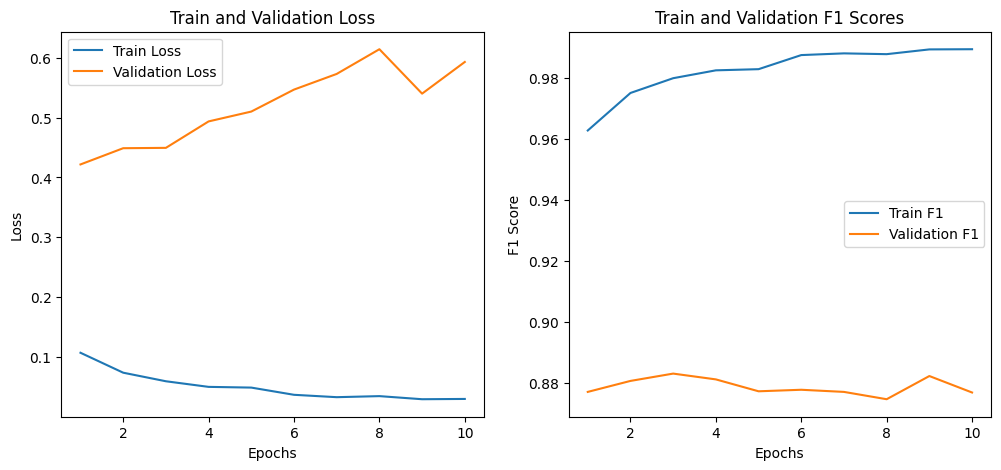

In [7]:
import matplotlib.pyplot as plt

# Function to train the model and return the metrics
def train_and_plot(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate F1 score
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_f1 = correct_train / total_train

        # Validation step
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate F1 score
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_f1 = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    # F1 Scores
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1')
    plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Train and Validation F1 Scores')

    plt.show()

# Now, use the function to tune the learning rate and plot the metrics
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Example of tuning the learning rate
train_and_plot(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Files already downloaded and verified
Epoch 1/10, Train Loss: 0.5119, Train F1: 0.8444, Val Loss: 0.3435, Val F1: 0.8883
Epoch 2/10, Train Loss: 0.3646, Train F1: 0.8731, Val Loss: 0.3272, Val F1: 0.8967
Epoch 3/10, Train Loss: 0.3335, Train F1: 0.8835, Val Loss: 0.3307, Val F1: 0.8920
Epoch 4/10, Train Loss: 0.3108, Train F1: 0.8922, Val Loss: 0.3497, Val F1: 0.8916
Epoch 5/10, Train Loss: 0.2924, Train F1: 0.8981, Val Loss: 0.3214, Val F1: 0.8968
Epoch 6/10, Train Loss: 0.2787, Train F1: 0.9012, Val Loss: 0.3056, Val F1: 0.9037
Epoch 7/10, Train Loss: 0.2635, Train F1: 0.9071, Val Loss: 0.3053, Val F1: 0.9021
Epoch 8/10, Train Loss: 0.2486, Train F1: 0.9123, Val Loss: 0.3320, Val F1: 0.9026
Epoch 9/10, Train Loss: 0.2379, Train F1: 0.9167, Val Loss: 0.3120, Val F1: 0.9017
Epoch 10/10, Train Loss: 0.2274, Train F1: 0.9210, Val Loss: 0.2922, Val F1: 0.9073


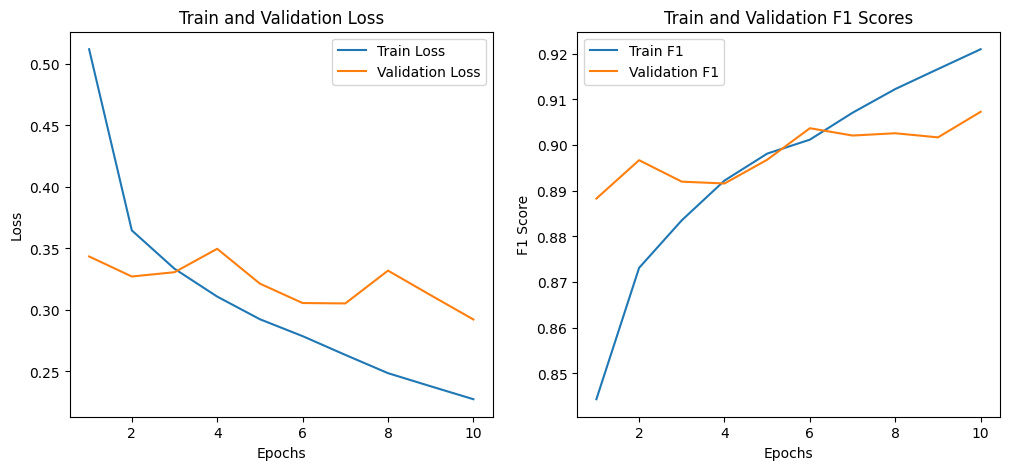

In [8]:
# Augmented transformation for training
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Rotate the image by up to 15 degrees
    transforms.RandomCrop(32, padding=4),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply this transformation to the train dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_augmented)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# Retrain the model with augmented data
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_and_plot(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

In [9]:
import time
import torch

# Function to measure the latency (inference time) for a single image
def measure_latency(model, device, input_image):
    model.eval()  # Set the model to evaluation mode
    input_image = input_image.to(device)  # Move the image to the appropriate device

    # Measure the start time
    start_time = time.time()

    # Perform inference
    with torch.no_grad():  # No need to calculate gradients during inference
        output = model(input_image.unsqueeze(0))  # Add batch dimension

    # Measure the end time and calculate latency
    end_time = time.time()
    latency = end_time - start_time
    return latency

# Example: Use a random image from the validation set
example_image, _ = val_loader.dataset[0]  # Pick the first image from the validation set
latency = measure_latency(model, device, example_image)

print(f"Inference latency per image: {latency:.6f} seconds")

Inference latency per image: 0.005034 seconds


In [10]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.3 MB/s eta 0:00:00


In [11]:
import torch.onnx

# Convert model to ONNX format
onnx_model_path = "model.onnx"
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Example input tensor (batch_size=1, channels=3, 32x32 image)
torch.onnx.export(model, dummy_input, onnx_model_path, opset_version=11)
print(f"Model exported to {onnx_model_path}")


Model exported to model.onnx


In [12]:
!ls

best_resnet_model.pth  data  model.onnx  sample_data


In [13]:
!apt-get install -y python3-libnvinfer-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libnvinfer-dev libnvinfer-dispatch-dev libnvinfer-dispatch10 libnvinfer-headers-dev
  libnvinfer-headers-plugin-dev libnvinfer-lean-dev libnvinfer-lean10 libnvinfer-plugin-dev
  libnvinfer-plugin10 libnvinfer-vc-plugin-dev libnvinfer-vc-plugin10 libnvinfer10
  libnvonnxparsers-dev libnvonnxparsers10 python3-libnvinfer python3-libnvinfer-dispatch
  python3-libnvinfer-lean
The following NEW packages will be installed:
  libnvinfer-dev libnvinfer-dispatch-dev libnvinfer-dispatch10 libnvinfer-headers-dev
  libnvinfer-headers-plugin-dev libnvinfer-lean-dev libnvinfer-lean10 libnvinfer-plugin-dev
  libnvinfer-plugin10 libnvinfer-vc-plugin-dev libnvinfer-vc-plugin10 libnvinfer10
  libnvonnxparsers-dev libnvonnxparsers10 python3-libnvinfer python3-libnvinfer-dev
  python3-libnvinfer-dispatch python3-libnvinfer-lean
0 upgraded, 18 newly installe

In [14]:
!pip install nvidia-pyindex

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8419 sha256=dfe7295a0d8e668e8b5c13ebb4486ac47a8086e9e50fde8a930e9f0ee55b593b
  Stored in directory: /root/.cache/pip/wheels/49/d0/7d/b68b3665d16ee20355e65fb7ef48b7ca26533217d9f09924fe
Successfully built nvidia-pyindex


In [15]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp311-cp311-linux_x86_64.whl size=660362 sha256=37f87cbc42193b35ecdf74b39bf192d236b0ec39caf45f8996199e00130140da
  Stored in directory: /root/.cache/pip/wheels/76/66/50/c65e6116d7e0e16abe0f7c19b50327f76724ccfefbdc61a1b9
Successfully built pycuda


In [16]:
!apt-get install -y cuda

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Some packages could not be installed. This may mean that you have
requested an impossible situation or if you are using the unstable
distribution that some required packages have not yet been created
or been moved out of Incoming.
The following information may help to resolve the situation:

The following packages have unmet dependencies:
 nvidia-open : Depends: nvidia-driver-565-open (>= 565.57.01) but it is not installable or
                        nvidia-driver-565-server-open (>= 565.57.01) but it is not installable
E: Unable to correct problems, you have held broken packages.


In [19]:
!pip install nvidia-tensorrt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.8.0.43-py2.py3-none-any.whl size=42246 sha256=a0b007748fcef76f81c9b380db4a47bd4febad8dbdb0b2848c82abcada594d69
  Stored in directory: /root/.cache/pip/wheels/74/b9/22/cd396c2ef84d0f65b7ad3c218d00b8049e426d0fde196209bc
  Created wheel for tensorrt_cu12: filename=tensorrt_cu12-10.8.0.43-py2.py3-none-any.whl size=17595 sha256=1aa05decc2ca8dd7a11dfcd7315a165c3724b0b10bca9175c535d10bf4d8742a
  Stored in directory: /root/.cache/pip/wheels/ef/cf/7c/93e4012a84c44ffa5cf2a6a7ea03b282a8a19e17755808a9fb
Successfully built tensorrt tensorrt_cu12


In [20]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit  # Automatically initializes CUDA context

# Create a logger for TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# Function to build the TensorRT engine
def build_trt_engine(onnx_file_path, output_engine_path):
    # Load the ONNX model
    with open(onnx_file_path, 'rb') as f:
        onnx_model = f.read()

    # Create a builder and network for TensorRT
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(flags=1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)

    # Parse the ONNX model
    if not parser.parse(onnx_model):
        print("ERROR: Failed to parse the ONNX file.")
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        return None

    # Set the builder configurations
    config = builder.create_builder_config()
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)  # 1GB workspace size

    # Enable FP16 if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)

    # Build the serialized network
    serialized_engine = builder.build_serialized_network(network, config)
    if not serialized_engine:
        print("ERROR: Failed to build the TensorRT engine.")
        return None

    # Save the serialized engine to a file
    with open(output_engine_path, 'wb') as f:
        f.write(serialized_engine)
    print(f"TensorRT engine saved to {output_engine_path}")

    # Deserialize the engine
    runtime = trt.Runtime(TRT_LOGGER)
    engine = runtime.deserialize_cuda_engine(serialized_engine)

    return engine

# File paths
onnx_file = "model.onnx"  # Replace with your ONNX model file path
engine_file = "model_trt.engine"  # Path to save the TensorRT engine

# Build the TensorRT engine
engine = build_trt_engine(onnx_file, engine_file)
if engine:
    print("TensorRT engine created successfully!")
else:
    print("Failed to create TensorRT engine.")


TensorRT engine saved to model_trt.engine
TensorRT engine created successfully!


In [26]:
import tensorrt as trt
print(trt.__version__)


10.8.0.43


In [30]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit  # Automatically initializes CUDA context
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Create a logger for TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# Function to build the TensorRT engine
def build_trt_engine(onnx_file_path, output_engine_path):
    # Load the ONNX model
    with open(onnx_file_path, 'rb') as f:
        onnx_model = f.read()

    # Create a builder and network for TensorRT
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(flags=1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)

    # Parse the ONNX model
    if not parser.parse(onnx_model):
        print("ERROR: Failed to parse the ONNX file.")
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        return None

    # Set the builder configurations
    config = builder.create_builder_config()
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)  # 1GB workspace size

    # Enable FP16 if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)

    # Build the serialized network
    serialized_engine = builder.build_serialized_network(network, config)
    if not serialized_engine:
        print("ERROR: Failed to build the TensorRT engine.")
        return None

    # Save the serialized engine to a file
    with open(output_engine_path, 'wb') as f:
        f.write(serialized_engine)
    print(f"TensorRT engine saved to {output_engine_path}")

    # Deserialize the engine
    runtime = trt.Runtime(TRT_LOGGER)
    engine = runtime.deserialize_cuda_engine(serialized_engine)

    return engine

# Function to allocate buffers for input and output
def allocate_buffers(engine):
    input_index = 0  # Adjust based on your model's input index
    output_index = 1  # Adjust based on your model's output index

    # Get input and output dimensions using get_binding_dimensions (correct method)
    input_shape = engine.get_binding_dimensions(input_index)  # Use get_binding_dimensions instead of get_binding_shape
    output_shape = engine.get_binding_dimensions(output_index)

    # Allocate memory for input and output buffers based on shapes obtained from bindings
    h_input = np.empty(trt.volume(input_shape), dtype=np.float32)  # Host input buffer (flattened)
    d_input = cuda.mem_alloc(h_input.nbytes)                       # Device input buffer
    h_output = np.empty(trt.volume(output_shape), dtype=np.float32) # Host output buffer (flattened)
    d_output = cuda.mem_alloc(h_output.nbytes)                     # Device output buffer

    stream = cuda.Stream()  # Create CUDA stream

    return h_input, d_input, h_output, d_output, stream

# Function to perform inference using TensorRT
def infer(engine, h_input, d_input, h_output, d_output, stream):
    context = engine.create_execution_context()

    # Transfer input data to the device
    cuda.memcpy_htod_async(d_input, h_input, stream)

    # Execute the model
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)

    # Transfer output data back to the host
    cuda.memcpy_dtoh_async(h_output, d_output, stream)

    # Synchronize the stream
    stream.synchronize()

# Main function to run everything together
def main():
    onnx_file = "model.onnx"  # Replace with your ONNX model file path
    engine_file = "model_trt.engine"  # Path to save the TensorRT engine

    # Build the TensorRT engine from ONNX model if it doesn't exist already.
    engine = build_trt_engine(onnx_file, engine_file)

    if not engine:
        print("Failed to create TensorRT engine.")
        return

    print("TensorRT engine created successfully!")

    # Allocate buffers for input and output for inference
    h_input, d_input, h_output, d_output, stream = allocate_buffers(engine)

   # Generate dummy input data (replace this with actual input data)
    h_input[...] = np.random.rand(*h_input.shape).astype(np.float32)

   # Perform inference using TensorRT
    infer(engine, h_input, d_input, h_output, d_output, stream)

   # Print the output results (for demonstration purposes)
    print("Output from TensorRT inference:", h_output)

if __name__ == "__main__":
   main()


TensorRT engine saved to model_trt.engine
TensorRT engine created successfully!


AttributeError: 'tensorrt_bindings.tensorrt.ICudaEngine' object has no attribute 'get_binding_dimensions'

In [44]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit  # Automatically initializes CUDA context
import numpy as np

# Create a logger for TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# Function to build and save the TensorRT engine
def build_and_save_trt_engine(onnx_file_path, output_engine_path):
    # Load the ONNX model
    with open(onnx_file_path, 'rb') as f:
        onnx_model = f.read()

    # Create a builder and network for TensorRT
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(flags=1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)

    # Parse the ONNX model
    if not parser.parse(onnx_model):
        print("ERROR: Failed to parse the ONNX file.")
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        return None

    # Set the builder configurations
    config = builder.create_builder_config()
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)  # 1GB workspace size

    # Enable FP16 if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)

    # Build the serialized network
    serialized_engine = builder.build_serialized_network(network, config)
    if not serialized_engine:
        print("ERROR: Failed to build the TensorRT engine.")
        return None

    # Save the serialized engine to a file
    with open(output_engine_path, 'wb') as f:
        f.write(serialized_engine)
    print(f"TensorRT engine saved to {output_engine_path}")

    return serialized_engine  # Return serialized engine for further use if needed

# Main function to run everything together
def main():
    onnx_file = "model.onnx"  # Replace with your ONNX model file path
    engine_file = "model_trt.engine"  # Path to save the TensorRT engine

   # Build and save the TensorRT engine from ONNX model
    build_and_save_trt_engine(onnx_file, engine_file)

if __name__ == "__main__":
   main()

TensorRT engine saved to model_trt.engine
